In [1]:
from __future__ import print_function

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal, beta

from emcee import EnsembleSampler
from emcee import autocorr
import corner

kf = 4.740471

np.random.seed(42)

%matplotlib inline

In [2]:
inputfile = "GaiaSource_1584380076484244352_2200921635402776448.csv"

In [3]:
colnames = ['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 
            'ra', 'ra_error', 'dec', 'dec_error', 
            'parallax', 'parallax_error', 'parallax_over_error', 
            'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
            'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
            'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 
            'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
            'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 
            'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 
            'astrometric_excess_noise', 'astrometric_excess_noise_sig', 
            'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al',
            'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 
            'mean_varpi_factor_al', 'astrometric_matched_observations', 
            'visibility_periods_used', 'astrometric_sigma5d_max', 
            'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 
            'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 
            'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_n_obs', 
            'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error', 
            'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux', 
            'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag', 
            'phot_bp_rp_excess_factor', 'phot_proc_mode', 'bp_rp', 'bp_g', 'g_rp', 
            'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 
            'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'phot_variable_flag', 
            'l', 'b', 'ecl_lon', 'ecl_lat', 'priam_flags', 'teff_val', 
            'teff_percentile_lower', 'teff_percentile_upper', 'a_g_val', 
            'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val', 
            'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper', 'flame_flags', 
            'radius_val', 'radius_percentile_lower', 'radius_percentile_upper', 'lum_val', 
            'lum_percentile_lower', 'lum_percentile_upper']

#### Reading

In [4]:
def read_file(n):
    """n = number of line"""
    count = 0
    dataline = []
    with open(inputfile, "r") as ifile:
        header = ifile.readline()
        for line in ifile:
            dataline.append(line.strip().split(","))
            count += 1
            if count >= n:
                break
    
    return dataline

In [5]:
data = read_file(5)

In [6]:
print(data[0][:26],)

['1635721458409799680', 'Gaia DR2 1584380076484244352', '1584380076484244352', '762438592', '2015.5', '182.8755581883795', '0.0212790242395056', '63.54138234954197', '0.01966600327720234', '1.993074195189996', '0.02400639851553525', '83.02262', '3.234628009532307', '0.04143244937602665', '-6.291124251194186', '0.04055069038309478', '0.27259696', '-0.3608034', '-0.31833214', '-0.10231504', '-0.15753631', '-0.19111045', '-0.4288791', '0.24472894', '-0.08114585', '0.27824137']


In [7]:
print(colnames[:26],)
print(colnames[66:68])

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr']
['radial_velocity', 'radial_velocity_error']


### Test on the first star

In [8]:
# first star, i=0
astro3d = [float(data[0][9]), float(data[0][12]), float(data[0][14])]
astromdat = [float(data[0][10]), float(data[0][13]), float(data[0][15]),
             float(data[0][23]), float(data[0][24]), float(data[0][25])]

print(astro3d)
print(astromdat)

[1.993074195189996, 3.234628009532307, -6.291124251194186]
[0.02400639851553525, 0.04143244937602665, 0.04055069038309478, 0.24472894, -0.08114585, 0.27824137]


### Without MCMC

In [9]:
def astro3d_to_phase3d(astro3d):
    """
    astro3d = [parallax in mas, pmra in mas/year (*cos(dec)), pmdec in mas/year]
    
    Return phase3d = [distance in pc, tangential speed in km/s, direction angle in rad]
    """
    dist = 1e3/astro3d[0]
    speed = kf*math.sqrt(astro3d[1]*astro3d[1] + astro3d[2]*astro3d[2])/astro3d[0]
    phi = math.atan2(astro3d[1], astro3d[2])
    
    return (dist, speed, phi) # pc, km/s, rad (-pi, pi)


def jacobian(astro3d):
    """
    There is an error in the original code
    
    Return Jacobian matrix
    """
    musq = astro3d[1]*astro3d[1] + astro3d[2]*astro3d[2]
    mu = math.sqrt(musq)
    J = [[-1e3/astro3d[0]**2, 0, 0],
         [-kf*mu/astro3d[0]**2, kf*astro3d[1]/(mu*astro3d[0]), kf*astro3d[2]/(mu*astro3d[0])],
         [0, astro3d[2]/musq, -astro3d[1]/musq]]
    
    return J


def covariance(astromdat):
    """
    astromdat = [parallax_error, pmra_error, pmdec_error, 
                 parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr]
                 
    Return astro3d covariance matrix
    """
    parallax_pmra = astromdat[0]*astromdat[1]*astromdat[3]
    parallax_pmdec = astromdat[0]*astromdat[2]*astromdat[4]
    pmra_pmdec = astromdat[1]*astromdat[2]*astromdat[5]
    
    cov = [[astromdat[0]**2, parallax_pmra, parallax_pmdec],
           [parallax_pmra, astromdat[1]**2, pmra_pmdec],
           [parallax_pmdec, pmra_pmdec, astromdat[2]**2]]
    
    return cov

In [10]:
phase3d_nom = astro3d_to_phase3d(astro3d)
jac = jacobian(astro3d)
astro3d_cov = covariance(astromdat)

jac = np.array(jac)
astro3d_cov = np.array(astro3d_cov)

phase3d_cov = jac*astro3d_cov*jac.T
phase3d_sigma = np.sqrt(phase3d_cov.diagonal())

In [11]:
print("Phase3D nominal: \n", phase3d_nom)
print("Jacobian: \n", jac)
print("Astro3D Cov: \n", astro3d_cov)
print("Phase3D Cov: \n", phase3d_cov)
print("Phase3D sigma: \n", phase3d_sigma)

Phase3D nominal: 
 (501.7374678842159, 16.82524085378268, 2.666683387639403)
Jacobian: 
 [[ -2.51740487e+02   0.00000000e+00   0.00000000e+00]
 [ -8.44185374e+00   1.08757473e+00  -2.11525645e+00]
 [  0.00000000e+00  -1.25719238e-01  -6.46394748e-02]]
Astro3D Cov: 
 [[  5.76307170e-04   2.43418145e-04  -7.89935402e-05]
 [  2.43418145e-04   1.71664786e-03   4.67477340e-04]
 [ -7.89935402e-05   4.67477340e-04   1.64435849e-03]]
Phase3D Cov: 
 [[  3.65224714e+01  -0.00000000e+00  -0.00000000e+00]
 [ -0.00000000e+00   2.03048336e-03   1.24315514e-04]
 [ -0.00000000e+00   1.24315514e-04   6.87056010e-06]]
Phase3D sigma: 
 [  6.04338245e+00   4.50608850e-02   2.62117533e-03]


### With MCMC

In [12]:
def ln_like(phase3d, astro3d, astro3dcov):
    """ln(likelihood)"""
    a = phase3d[1]/(kf*phase3d[0]) # pm = vt/(4.74*d)
    prlx = 1.0e3/phase3d[0] # mas
    pmr = 1.0e3*a*math.sin(phase3d[2]) # mas/year
    pmd = 1.0e3*a*math.cos(phase3d[2]) # mas/year
    
    likelihood = multivariate_normal.pdf(x=astro3d, mean=(prlx, pmr, pmd), cov=astro3dcov)
    return np.log(likelihood)

def ln_prior(phase3d, rlen, vtmax):
    """ln(prior)"""
    # distance prior
    if phase3d[0] > 0: # positive distance
        # exponentially decreasing space density
        ln_dist_prior = 0.0 - np.log(2 * rlen**3) + 2*np.log(phase3d[0]) - (phase3d[0]/rlen) 
    else:
        ln_dist_prior = -np.inf
    
    # speed prior
    speed_prior = beta.pdf(phase3d[1]/vtmax, a=2.0, b=3.0)
    ln_speed_prior = np.log(speed_prior)
    
    # direction angle prior
    ln_angle_prior = 0.0
    
    return ln_dist_prior + ln_speed_prior + ln_angle_prior

def ln_pos(phase3d, astro3d, astro3dcov, rlen, vtmax):
    """
    ln(posterior)
    """
    lnprior = ln_prior(phase3d, rlen, vtmax)
    lnlike = ln_like(phase3d, astro3d, astro3dcov)
    if not np.isfinite(lnprior):
        return -np.inf
    return lnlike + lnprior


def init_walker(Nwalker, phase3d, vtmax):
    """Initiate walker population parameters"""
    dist_width  = 0.05*phase3d[0]
    half_dist_width = dist_width/2.0
    if (phase3d[0] < half_dist_width):
        dist = np.random.uniform(0.0, dist_width, Nwalker)
    else:
        dist = np.random.uniform(phase3d[0]-half_dist_width, phase3d[0]+half_dist_width, Nwalker)
        
    speed_width = 0.1*phase3d[1]
    half_speed_width = speed_width/2.0
    if (phase3d[1] < half_speed_width):
        speed = np.random.uniform(0.0, speed_width, Nwalker)
    elif (phase3d[1] > vtmax-half_speed_width):
        speed = np.random.uniform(vtmax-speed_width, vtmax, Nwalker)
    else:
        speed = np.random.uniform(phase3d[1]-half_speed_width, phase3d[1]+half_speed_width, Nwalker)
    
    half_angle_width = 0.2 # radian
    angle = np.random.uniform(phase3d[2]-half_angle_width, phase3d[2]+half_angle_width, Nwalker)
    
    return np.vstack((dist, speed, angle)).T

In [13]:
Nwalker = 100
mc_iter = 1500
npar = 3
vtmax = 1000.0
rlen = 1000.0

#### Initiate walker

In [14]:
init_pop = init_walker(Nwalker, phase3d_nom, 900)

#### Run MCMC

In [15]:
sampler = EnsembleSampler(Nwalker, npar, ln_pos, args=(astro3d, astro3d_cov, rlen, vtmax))

In [16]:
sampler.run_mcmc(init_pop, mc_iter);

/home/ridlo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


#### Overview

In [17]:
def plot_chain(walkerchain, npar=3, par_names=[r"$d$", r"$v_t$", r"$\theta$"]):
    x_size = 10.0
    y_size = 2.0*npar
    
    fig, axs = plt.subplots(npar, 1, figsize=(x_size, y_size), sharex=True)
    
    ls = ['-','--','--']
    lc = ['k', '0.5', '0.5']
    
    percs = []
    for i in range(npar):
        percs.append(np.percentile(walkerchain[:,:,i], [50,16,84], 0))
    
    for i in range(npar):
        axs.flat[i].plot(walkerchain[:,:,i].T, 'k', alpha=0.01)
    
    for i in range(npar):
        for j in range(3):
            axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j])
    
    for i in range(npar):
        axs.flat[i].set_ylabel(par_names[i])
            
    fig.tight_layout()

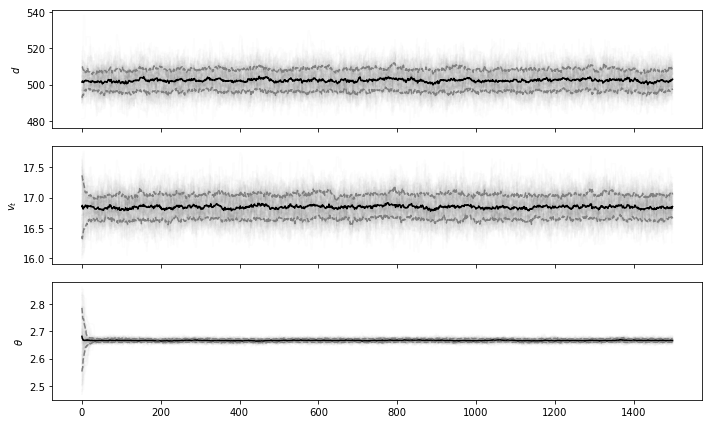

In [18]:
plot_chain(sampler.chain)

In [19]:
print(sampler.chain.shape)

autocor = autocorr.integrated_time(sampler.chain.reshape((-1, npar)), c=10, axis=0)
print('autocor = ', autocor)
mean_autocor = int(np.mean(autocor))
print('mean = ', mean_autocor)

(100, 1500, 3)
autocor =  [ 37.00165117  37.71537545  26.83657655]
mean =  33


#### Burn-it all baby

In [20]:
burn = int(mc_iter/5.)
thin = mean_autocor
walkers = sampler.chain[:, burn::thin, :]
print(walkers.shape)
samples = walkers.reshape((-1, npar)) # for cornerplot, nsamples, n_parameter
print(samples.shape)

(100, 37, 3)
(3700, 3)


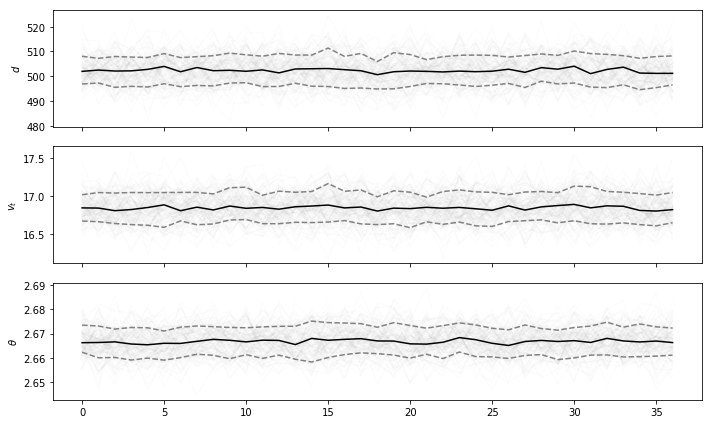

In [21]:
plot_chain(walkers)

#### Corner Plot

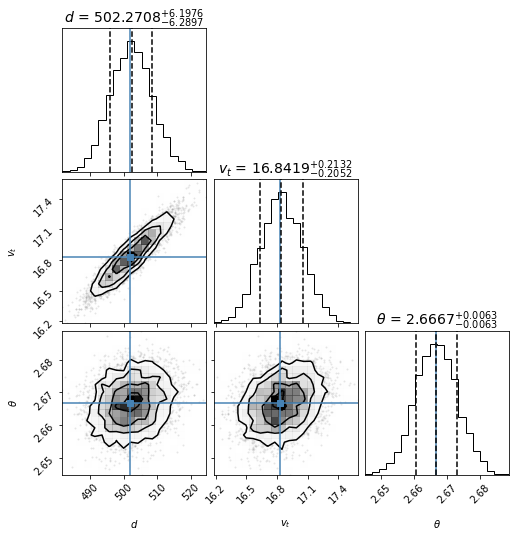

In [22]:
fig = corner.corner(samples, quantiles=(0.16, 0.5, 0.84), show_titles=True, title_fmt='.4f', \
                    truths=phase3d_nom, \
                    labels=[r'$d$', r'$v_{t}$', r'$\theta$'], title_kwargs={"fontsize": 14})

In [23]:
phase3d_mcmc =  np.zeros(npar*3).reshape((npar, 3)) 
par_names = ['d', 'vt', 'theta']

print("With MCMC:")
for i in range(npar):
    phase3d_mcmc[i,:]  = corner.quantile(samples[:,i], [0.16, 0.5, 0.84]) # median = theta[:,1]
    print(par_names[i], "\t = ", phase3d_mcmc[i,1], "\t +- ", \
          [phase3d_mcmc[i,2]-phase3d_mcmc[i,1], \
          phase3d_mcmc[i,0]-phase3d_mcmc[i,1]])

print("\nWithout MCMC:")
for i in range(npar):
    print(par_names[i], "\t = ", phase3d_nom[i], "\t +-\t", phase3d_sigma[i])

With MCMC:
d 	 =  502.270833948 	 +-  [6.1975744789099849, -6.2897252314541561]
vt 	 =  16.8419102994 	 +-  [0.21315944461366598, -0.20519492364418213]
theta 	 =  2.66673902292 	 +-  [0.0063134215698172902, -0.0062897852382954866]

Without MCMC:
d 	 =  501.737467884 	 +-	 6.04338244571
vt 	 =  16.8252408538 	 +-	 0.0450608850043
theta 	 =  2.66668338764 	 +-	 0.00262117532745
